In [1]:
pip install git+https://github.com/dbouget/raidionics_rads_lib.git

  Cloning https://github.com/dbouget/raidionics_rads_lib.git to /tmp/pip-req-build-7p8u___e
  Running command git clone --filter=blob:none --quiet https://github.com/dbouget/raidionics_rads_lib.git /tmp/pip-req-build-7p8u___e
  Resolved https://github.com/dbouget/raidionics_rads_lib.git to commit b28658af54fe46cbcf3e926431192a527fbb7676
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/dbouget/raidionics_seg_lib.git (to revision master) to /tmp/pip-install-5l117gjw/raidionicsseg_6b5d38eee0e64e9aa5d71585599f5798
  Running command git clone --filter=blob:none --quiet https://github.com/dbouget/raidionics_seg_lib.git /tmp/pip-install-5l117gjw/raidionicsseg_6b5d38eee0e64e9aa5d71585599f5798
  Resolved https://github.com/dbouget/raidionics_seg_lib.git to commit cc502d8f26ca995c4ffaf716d0bcba982c7a1a9e
  Installing build

In [28]:
#Download the test data
import os
import requests
import zipfile

test_image_url = 'https://github.com/raidionics/Raidionics-models/releases/download/v1.3.0-rc/Samples-RaidionicsRADSLib-UnitTest1.zip'
brain_model_url = 'https://github.com/raidionics/Raidionics-models/releases/download/v1.3.0-rc/Raidionics-MRI_Brain-v13.zip'
seq_model_url = 'https://github.com/raidionics/Raidionics-models/releases/download/v1.3.0-rc/Raidionics-MRI_SequenceClassifier-v13.zip'

test_dir = os.path.join(os.getcwd(), 'unit_tests_results_dir')
os.makedirs(test_dir, exist_ok=True)
patient_dir = os.path.join(test_dir, 'patient')
models_dir = os.path.join(test_dir, 'models')
results_dir = os.path.join(test_dir, 'results')
os.makedirs(patient_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

archive_dl_dest = os.path.join(test_dir, 'inference_patient.zip')
headers = {}
response = requests.get(test_image_url, headers=headers, stream=True)
response.raise_for_status()
if response.status_code == requests.codes.ok:
    with open(archive_dl_dest, "wb") as f:
        for chunk in response.iter_content(chunk_size=1048576):
            f.write(chunk)
with zipfile.ZipFile(archive_dl_dest, 'r') as zip_ref:
    zip_ref.extractall(patient_dir)

archive_dl_dest = os.path.join(test_dir, 'seq-model.zip')
headers = {}
response = requests.get(seq_model_url, headers=headers, stream=True)
response.raise_for_status()
if response.status_code == requests.codes.ok:
    with open(archive_dl_dest, "wb") as f:
        for chunk in response.iter_content(chunk_size=1048576):
            f.write(chunk)
with zipfile.ZipFile(archive_dl_dest, 'r') as zip_ref:
    zip_ref.extractall(models_dir)
            
archive_dl_dest = os.path.join(test_dir, 'brain-model.zip')
headers = {}
response = requests.get(brain_model_url, headers=headers, stream=True)
response.raise_for_status()
if response.status_code == requests.codes.ok:
    with open(archive_dl_dest, "wb") as f:
        for chunk in response.iter_content(chunk_size=1048576):
            f.write(chunk)
with zipfile.ZipFile(archive_dl_dest, 'r') as zip_ref:
    zip_ref.extractall(models_dir)


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): github.com:443
DEBUG:urllib3.connectionpool:https://github.com:443 "GET /raidionics/Raidionics-models/releases/download/v1.3.0-rc/Samples-RaidionicsRADSLib-UnitTest1.zip HTTP/1.1" 302 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): release-assets.githubusercontent.com:443
DEBUG:urllib3.connectionpool:https://release-assets.githubusercontent.com:443 "GET /github-production-release-asset/601122702/5ea31915-bda8-4111-8ef2-5a392031dccf?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-07-11T16%3A24%3A28Z&rscd=attachment%3B+filename%3DSamples-RaidionicsRADSLib-UnitTest1.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-07-11T15%3A24%3A13Z&ske=2025-07-11T16%3A24%3A28Z&sks=b&skv=2018-11-09&sig=UrL0ywHsM17dJ64Zhor3MWOffIwLdUy%2F5JxDMBH9b64%3D&jwt=eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l

In [29]:
# Download the pipeline
import os
import json

pipeline_dir = os.path.join(test_dir, 'pipelines')
os.makedirs(pipeline_dir, exist_ok=True)

pipeline_json = {}
step_index = 1
step_str = str(step_index)
pipeline_json[step_str] = {}
pipeline_json[step_str]["task"] = "Classification"
pipeline_json[step_str]["inputs"] = {}  # Empty input means running it on all existing data for the patient
pipeline_json[step_str]["target"] = ["MRSequence"]
pipeline_json[step_str]["model"] = "MRI_SequenceClassifier"
pipeline_json[step_str]["description"] = "Classification of the MRI sequence type for all input scans."

step_index = step_index + 1
step_str = str(step_index)
pipeline_json[step_str] = {}
pipeline_json[step_str]["task"] = "Segmentation"
pipeline_json[step_str]["inputs"] = {}
pipeline_json[step_str]["inputs"]["0"] = {}
pipeline_json[step_str]["inputs"]["0"]["timestamp"] = 0
pipeline_json[step_str]["inputs"]["0"]["sequence"] = "T1-CE"
pipeline_json[step_str]["inputs"]["0"]["labels"] = None
pipeline_json[step_str]["inputs"]["0"]["space"] = {}
pipeline_json[step_str]["inputs"]["0"]["space"]["timestamp"] = 0
pipeline_json[step_str]["inputs"]["0"]["space"]["sequence"] = "T1-CE"
pipeline_json[step_str]["target"] = "Brain"
pipeline_json[step_str]["model"] = "MRI_Brain"
pipeline_json[step_str]["format"] = "thresholding"
pipeline_json[step_str]["description"] = "Brain segmentation in T1-CE (T0)."

print(json.dumps(pipeline_json, indent=4))
with open(os.path.join(pipeline_dir, 'pipeline_brain_seg.json'), 'w', newline='\n') as outfile:
    json.dump(pipeline_json, outfile, indent=4, sort_keys=True)

{
    "1": {
        "task": "Classification",
        "inputs": {},
        "target": [
            "MRSequence"
        ],
        "model": "MRI_SequenceClassifier",
        "description": "Classification of the MRI sequence type for all input scans."
    },
    "2": {
        "task": "Segmentation",
        "inputs": {
            "0": {
                "timestamp": 0,
                "sequence": "T1-CE",
                "labels": null,
                "space": {
                    "timestamp": 0,
                    "sequence": "T1-CE"
                }
            }
        },
        "target": "Brain",
        "model": "MRI_Brain",
        "format": "thresholding",
        "description": "Brain segmentation in T1-CE (T0)."
    }
}


In [30]:
# Prepare the configuration file
import configparser
import json
import logging

test_results_dir = os.path.join(results_dir, "output_brain_seg")
os.makedirs(test_results_dir, exist_ok=True)

logging.basicConfig()
logging.getLogger().setLevel(logging.DEBUG)
rads_config = configparser.ConfigParser()
rads_config.add_section('Default')
rads_config.set('Default', 'task', 'neuro_diagnosis')
rads_config.set('Default', 'caller', '')
rads_config.add_section('System')
rads_config.set('System', 'gpu_id', "-1")
rads_config.set('System', 'input_folder', os.path.join(patient_dir, "patient-UnitTest1", "inputs"))
rads_config.set('System', 'output_folder', test_results_dir)
rads_config.set('System', 'model_folder', models_dir)
rads_config.set('System', 'pipeline_filename', os.path.join(pipeline_dir, 'pipeline_brain_seg.json'))
rads_config.add_section('Runtime')
rads_config.set('Runtime', 'reconstruction_method', 'thresholding')
rads_config.set('Runtime', 'reconstruction_order', 'resample_first')
rads_config_filename = os.path.join(results_dir, 'rads_config.ini')
with open(rads_config_filename, 'w') as outfile:
    rads_config.write(outfile)

In [31]:
# Run the segmentation task
from raidionicsrads.compute import run_rads
run_rads(rads_config_filename)


DEBUG:root:ANTs scripts directory: 
DEBUG:root:ANTs binary directory: 
INFO:root:Starting pipeline for file: /media/dbouget/ihdb/Code/Private/raidionics_rads_lib/notebooks/unit_tests_results_dir/pipelines/pipeline_brain_seg.json.
INFO:root:LOG: Pipeline setup - 2 steps.
INFO:root:LOG: Pipeline - Classification of the MRI sequence type for all input scans. - Begin (1/2)
INFO:root:Starting inference for folder: inputs, with model: /media/dbouget/ihdb/Code/Private/raidionics_rads_lib/notebooks/unit_tests_results_dir/models/MRI_SequenceClassifier.
INFO:root:LOG: Classification - 3 steps.
INFO:root:LOG: Classification - Preprocessing - Begin (1/3)
DEBUG:root:Preprocessing - Extracting input data.
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
DEBUG:root:Preprocessing - Resampling.
DEBUG:root:Preprocessing - Background clipping.
DEBUG:root:MRI background cropping with: [14, 18, 46, 194, 222, 

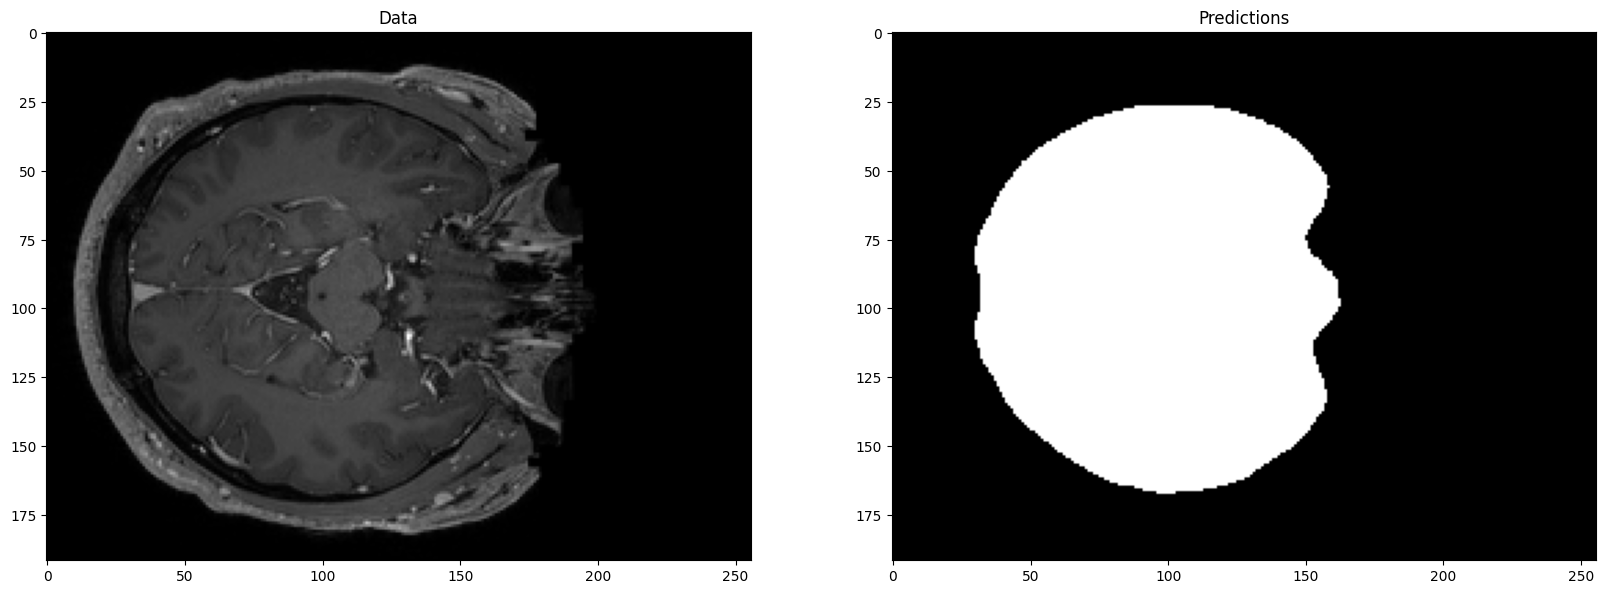

In [33]:
# Inspect the results
import nibabel as nib
import matplotlib.pyplot as plt

logging.getLogger().setLevel(logging.WARNING)
data_filename = os.path.join(patient_dir, "patient-UnitTest1", "inputs", 'T0', 'input1.nii.gz')
predictions_filename = os.path.join(test_results_dir, 'T0', 'input1_annotation-Brain_MRI_Brain.nii.gz')

data = nib.load(data_filename).get_fdata()[:]
predictions = nib.load(predictions_filename).get_fdata()[:]

predictions[predictions < 0.5] = 0
predictions[predictions >= 0.5] = 1

# plot corresponding data and predictions for a single 2D slice
slice_nr = 120
fig, ax = plt.subplots(1, 2, figsize=(20, 12))
ax[0].imshow(data[..., slice_nr], cmap="gray")
ax[1].imshow(predictions[..., slice_nr], cmap="gray")

for i, title in enumerate(["Data", "Predictions"]):
  ax[i].set_title(title)
plt.show()